In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PROBLEM #1

# get Data
df = yf.download('AAPL', start='2016-01-01', end='2016-12-01')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,23.946920,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.346825,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,22.889933,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,21.923876,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.039804,283192000


In [ ]:
# Part A

M = 231
chng = df['Close'].diff()
chng = chng.dropna() #where k=1
sumSqrs = (chng.head(M) ** 2).sum()
varEst = sumSqrs / M
print(sumSqrs, varEst)

# sanity check
# close = df['Close']
# sum = 0
# for i in range(1, len(df)):
#     sum += np.power(close[i] - close[i-1], 2)
# print(sum, sum/len(df))

34.33416375060915 0.14863274350913053


In [ ]:
# Part B

avgVol = df['Volume'].mean()
print(avgVol)

spread = 0.2
epsilon = spread / 2
eta = spread / (0.0001 * avgVol)
gamma = spread / (0.001 * avgVol)
print(epsilon, eta, gamma)

157120451.94805196
0.1 1.272908762164999e-05 1.272908762164999e-06


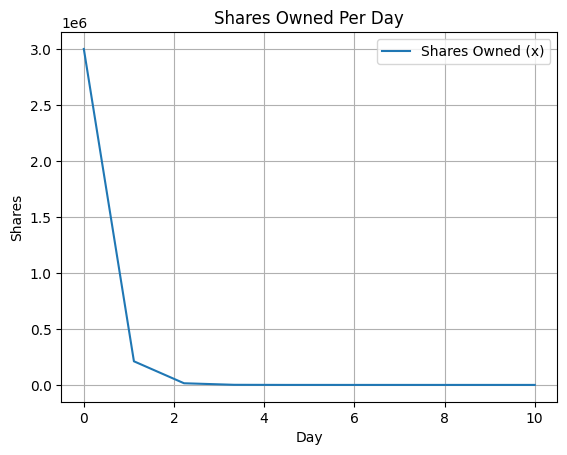

In [ ]:
# Part C
# for lambda = 0.001

X = 3000000
N = 10
T = 10
lmbda = 0.001
tau = T/N
eta_hat = eta - 0.5*gamma*tau
kappaSqrd = lmbda*varEst/eta_hat
kappa = (np.arccosh((kappaSqrd * np.power(tau, 2)/ 2) + 1)) / tau

# sanity check
# print(kappaSqrd)
# print(2*(np.cosh(kappa)-1))

x = np.empty(N)
n = np.empty(N)
for j in range(N):
    x[j] = ((np.sinh(kappa*(T-j))) / (np.sinh(kappa*T))) * X
    n[j] = ((2 * np.sinh(0.5 * kappa * tau)) / (np.sinh(kappa * T))) * np.cosh(kappa * (T - (j - 0.5) * tau)) * X
    # print(x[j])

plt.plot(np.linspace(0, 10, N), x, label='Shares Owned (x)')
plt.xlabel('Day')
plt.ylabel('Shares')
plt.title('Shares Owned Per Day')
plt.legend()
plt.grid(True)
plt.show()



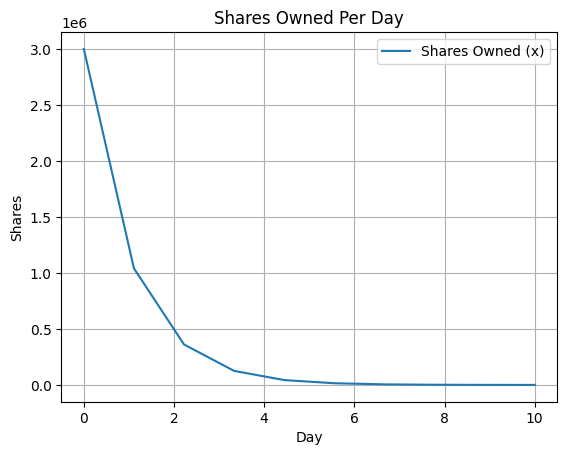

In [ ]:
# Part C
# for lambda = 0.0001

X = 3000000
N = 10
T = 10
lmbda = 0.0001
tau = T/N
eta_hat = eta - 0.5*gamma*tau
kappaSqrd = lmbda*varEst/eta_hat
kappa = (np.arccosh((kappaSqrd * np.power(tau, 2)/ 2) + 1)) / tau

# sanity check
# print(kappaSqrd)
# print(2*(np.cosh(kappa)-1))

x = np.empty(N)
n = np.empty(N)
for j in range(N):
    x[j] = ((np.sinh(kappa*(T-j))) / (np.sinh(kappa*T))) * X
    n[j] = ((2 * np.sinh(0.5 * kappa * tau)) / (np.sinh(kappa * T))) * np.cosh(kappa * (T - (j - 0.5) * tau)) * X
    # print(x[j])

plt.plot(np.linspace(0, 10, N), x, label='Shares Owned (x)')
plt.xlabel('Day')
plt.ylabel('Shares')
plt.title('Shares Owned Per Day')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# PROBLEM #2

# get Data
bit = pd.read_csv("/content/drive/My Drive/ISE537-HW4/Bitcoin_Price.csv", parse_dates=["datetime"])
# clean Data
bit.drop_duplicates(subset=['datetime'], keep='first', inplace=True)
print(bit)

                 datetime    price
0     2017-06-28 00:01:00  2344.00
2     2017-06-28 00:02:00  2337.18
4     2017-06-28 00:03:00  2335.02
6     2017-06-28 00:04:00  2341.99
8     2017-06-28 00:05:00  2343.98
...                   ...      ...
47666 2017-07-14 13:14:00  2320.22
47668 2017-07-14 13:15:00  2320.22
47670 2017-07-14 13:16:00  2322.55
47672 2017-07-14 13:17:00  2320.47
47674 2017-07-14 13:18:00  2320.47

[23838 rows x 2 columns]


In [ ]:
# Step 1

data = bit.filter(['price'])
dataset = data.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.22995953],
       [0.21487804],
       [0.2101015 ],
       ...,
       [0.18252582],
       [0.17792618],
       [0.17792618]])

In [ ]:
# Step 2

training_data_len = int(np.ceil( len(dataset) * .80 ))
print(training_data_len)

19071


In [ ]:
# Step 3

train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []
for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 11:
        print(x_train)
        print(y_train)
        print()
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

test_data = scaled_data[training_data_len - 10: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

[array([0.22995953, 0.21487804, 0.2101015 , 0.22551469, 0.2299153 ,
       0.21229075, 0.22111408, 0.24636784, 0.22332545, 0.22115831])]
[0.21669136020875257]

[array([0.22995953, 0.21487804, 0.2101015 , 0.22551469, 0.2299153 ,
       0.21229075, 0.22111408, 0.24636784, 0.22332545, 0.22115831]), array([0.21487804, 0.2101015 , 0.22551469, 0.2299153 , 0.21229075,
       0.22111408, 0.24636784, 0.22332545, 0.22115831, 0.21669136])]
[0.21669136020875257, 0.23438225603148943]



In [ ]:
# Step 4

model = Sequential()
model.add(LSTM(4, input_shape= (x_train.shape[1], 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(x_train, y_train, batch_size=256, epochs=100, verbose=2)

Epoch 1/100
75/75 - 4s - loss: 0.9194 - 4s/epoch - 48ms/step
Epoch 2/100
75/75 - 1s - loss: 0.2840 - 605ms/epoch - 8ms/step
Epoch 3/100
75/75 - 1s - loss: 0.0613 - 620ms/epoch - 8ms/step
Epoch 4/100
75/75 - 1s - loss: 0.0212 - 623ms/epoch - 8ms/step
Epoch 5/100
75/75 - 1s - loss: 0.0168 - 510ms/epoch - 7ms/step
Epoch 6/100
75/75 - 0s - loss: 0.0154 - 438ms/epoch - 6ms/step
Epoch 7/100
75/75 - 0s - loss: 0.0140 - 447ms/epoch - 6ms/step
Epoch 8/100
75/75 - 0s - loss: 0.0126 - 431ms/epoch - 6ms/step
Epoch 9/100
75/75 - 0s - loss: 0.0112 - 430ms/epoch - 6ms/step
Epoch 10/100
75/75 - 0s - loss: 0.0099 - 421ms/epoch - 6ms/step
Epoch 11/100
75/75 - 0s - loss: 0.0087 - 440ms/epoch - 6ms/step
Epoch 12/100
75/75 - 0s - loss: 0.0075 - 418ms/epoch - 6ms/step
Epoch 13/100
75/75 - 0s - loss: 0.0065 - 433ms/epoch - 6ms/step
Epoch 14/100
75/75 - 0s - loss: 0.0054 - 426ms/epoch - 6ms/step
Epoch 15/100
75/75 - 0s - loss: 0.0045 - 437ms/epoch - 6ms/step
Epoch 16/100
75/75 - 0s - loss: 0.0037 - 458ms/epoc

In [ ]:
# Part A

# train error
train_predictions = model.predict(x_train)
train_predictions = scaler.inverse_transform(train_predictions)
train_rmse = np.sqrt(np.mean(((train_predictions - dataset[10:training_data_len]) ** 2)))
print(train_rmse)
# test error
test_predictions = model.predict(x_test)
test_predictions = scaler.inverse_transform(test_predictions)
test_rmse = np.sqrt(np.mean(((test_predictions - y_test) ** 2)))
print(test_rmse)

596/596 [==============================] - 3s 5ms/step
5.133156923107918
149/149 [==============================] - 0s 3ms/step
18.240660331197336


<ipython-input-69-d3f6a16de663>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction['Predictions'] = train_predictions[start-10:training_data_len]
<ipython-input-69-d3f6a16de663>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tstprediction['Predictions'] = test_predictions


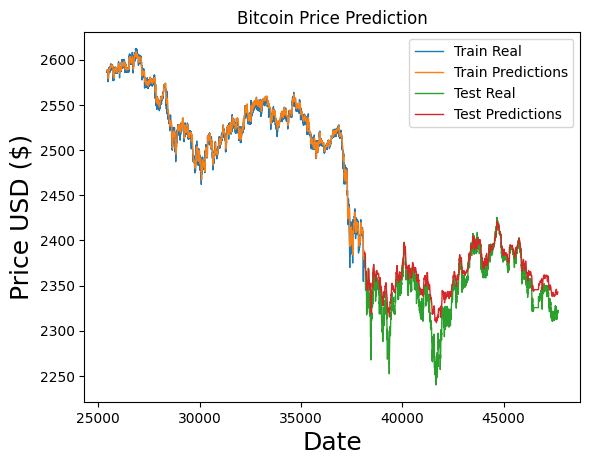

In [ ]:
# Part B

start = int(2/3 * training_data_len)
prediction = data[start:training_data_len]
prediction['Predictions'] = train_predictions[start-10:training_data_len]
tstprediction = data[training_data_len:]
tstprediction['Predictions'] = test_predictions
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price USD ($)', fontsize=18)
plt.plot(prediction[['price', 'Predictions']], linewidth=1)
plt.plot(tstprediction[['price', 'Predictions']], linewidth=1)
plt.legend(['Train Real', 'Train Predictions', 'Test Real', 'Test Predictions'], loc='upper right')
plt.show()